# CNN Monkey Dataset
## By Andrew Nguyen (AXN210071) and Aaron Fredericks (ajf220004)

CNN structure inspired by CNN Repo: https://colab.research.google.com/github/a-nagar/cs4372/blob/main/CNN_transfer_learning_modified.ipynb#scrollTo=K5BeQyKThC_Y

Original dataset: https://www.kaggle.com/code/paultimothymooney/identify-monkey-species-from-image/notebook

In [150]:
import os, glob, numpy as np, matplotlib.pyplot as plt, tensorflow as tf, pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV as GridSearchCV
import kagglehub
import keras_hub
import keras
from keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds

# PreProcessing

In [151]:
#imports monkey data from kaggle
DATA_ROOT = kagglehub.dataset_download("slothkong/10-monkey-species")

path_label = os.path.join(DATA_ROOT, "monkey_labels.txt")

#Helps properly define path to dataset, as the dataset is nested
def resolve_split(root, split):
    p = os.path.join(root, split)
    nested = os.path.join(p, split)
    return nested if os.path.isdir(nested) else p

train_dir = resolve_split(DATA_ROOT, "training")
val_dir   = resolve_split(DATA_ROOT, "validation")
label = path_label

#print out where the directories are located for easier access
print('Location of train dir:', train_dir)
print('Location of val dir:', val_dir)

Using Colab cache for faster access to the '10-monkey-species' dataset.
Location of train dir: /kaggle/input/10-monkey-species/training/training
Location of val dir: /kaggle/input/10-monkey-species/validation/validation


In [152]:
#Prints out all the labels and what they mean (Given by creator of dataset)
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv(path_label, names=cols, skiprows=1)
labels

Label                Latin Name                      Common Name  \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

   Train Images  Validation Images  
0           131                 26  
1           139                 28  
2           137                 27  
3           152                 30  
4           131                 26  
5           141                 28  
6           132                 26  
7           142                 28  
8           133                 27  
9           132                 26

In [153]:
#Hyper Parameters for Pre-Processing
batch = 30
seed = 1337
flip = "vertical"
rotation = 0.8
zoom = 0.5

In [154]:
#Properly create datasets from directories
img_size = (400, 300) #Unfortuntely, some of the photos in dataset are larger than img size, so it will be ignored
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, batch_size=batch,
    label_mode='int', shuffle=True, seed=seed, image_size=img_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, batch_size=batch,
    label_mode='int', shuffle=False, image_size=img_size)

class_names = train_ds.class_names

#Create test dataset, as we are not provided one
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

print('Before adding some train data to test data:')
print('Number of Train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of Validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of Test batches: %d' % tf.data.experimental.cardinality(test_ds))

#Add more to test dataset from training dataset, as adding from just validation dataset is not enough
train_batches = tf.data.experimental.cardinality(train_ds)
test_ds = train_ds.take(train_batches // 4)
train_ds = train_ds.skip(train_batches // 4)

print('After adding some train data to test data:')
print('Number of Train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of Validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of Test batches: %d' % tf.data.experimental.cardinality(test_ds))

Found 1097 files belonging to 10 classes.
Found 272 files belonging to 10 classes.
Before adding some train data to test data:
Number of Train batches: 37
Number of Validation batches: 5
Number of Test batches: 5
After adding some train data to test data:
Number of Train batches: 28
Number of Validation batches: 5
Number of Test batches: 9


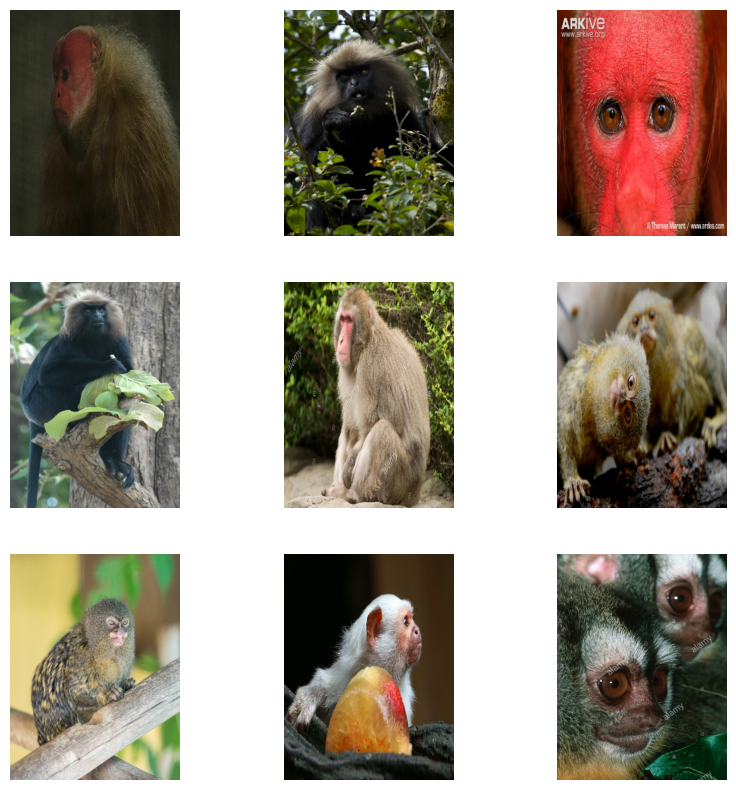

In [155]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [156]:
num_classes = len(labels)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [157]:
#Adds more modifications to training dataset for more data
augment = tf.keras.Sequential([
    layers.RandomFlip(flip),
    layers.RandomRotation(rotation),
    layers.RandomZoom(zoom),
], name="augment")

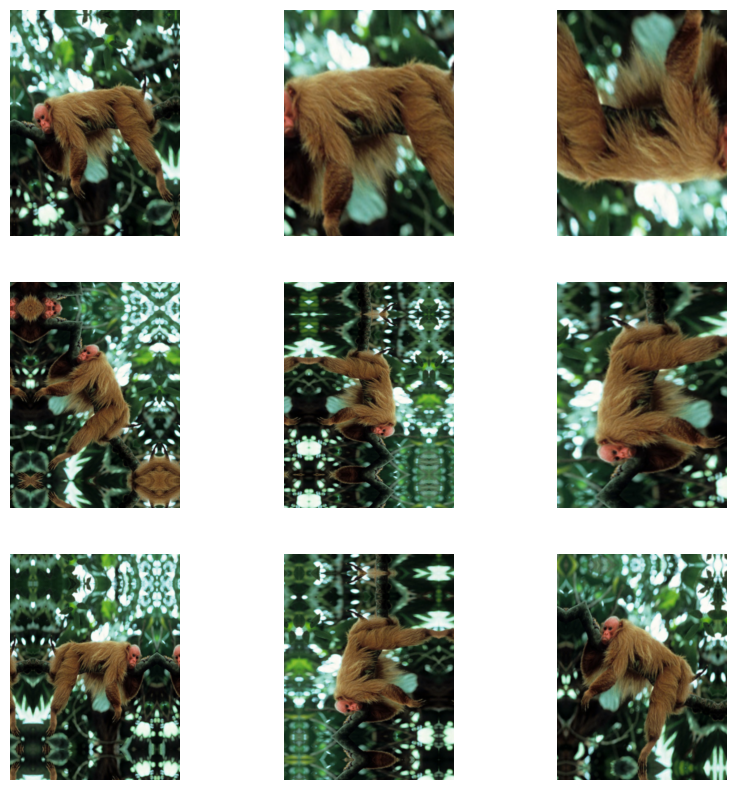

In [158]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augment(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# MobileNetV2

In [159]:
#Hyper Parameters for the MobileNetV2
alpha_val = 1
include_top_val = False
dropout_rate_val = 0.30
#For compliling model
optimizer_val = tf.keras.optimizers.AdamW()
optimizer_val_tuning = tf.keras.optimizers.AdamW(1e-4)
global_average_layer_parameter = tf.keras.layers.GlobalAveragePooling2D()
loss_val = "sparse_categorical_crossentropy"
base_learning_rate = 0.001
initial_epochs = 15
fine_tune_layers = 75
fine_tune_epochs = 12

In [160]:
#Use the MobileNetV2 Model for Assignment
classifier = tf.keras.applications.MobileNetV2(
    input_shape=(img_size[0], img_size[1], 3),
    alpha=alpha_val,
    include_top=include_top_val,
    weights="imagenet",
)

/tmp/ipython-input-2080077850.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  classifier = tf.keras.applications.MobileNetV2(


In [161]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = classifier(image_batch)
print(feature_batch.shape)

(30, 13, 10, 1280)


## Trainable = False
Sets classifier.trainable to false so that we cannot train the weights with our dataset and use the default weights

In [162]:
classifier.trainable = False

In [163]:
classifier.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 400, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 150,  │        864 │ input_layer_17[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 200, 150,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 200, 150,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 200, 150,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 200, 150,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 200, 150,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 200, 150,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 200, 150,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 200, 150,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 200, 150,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 200, 150,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 201, 151,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 100, 75,   │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 100, 75,   │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 100, 75,   │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 100, 75,   │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [164]:
#Adds more pooling and convert image to a single vector per image
global_average_layer = global_average_layer_parameter
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(30, 1280)


In [165]:
#Adds a prediction layer. Since multiple lables, softmax is the only prediction layer activation function
prediction_layer = tf.keras.layers.Dense(1000, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(30, 1000)


In [166]:
#Adds all of those layers and more
inputs = layers.Input((*img_size, 3))
x = augment(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = classifier(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(dropout_rate_val)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
classifier = models.Model(inputs, outputs) #combines all layers into a complete model

In [167]:
classifier.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 400, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 400, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_5 (TrueDivide)      │ (None, 400, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_5 (Subtract)           │ (None, 400, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 13, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 30)             │        38,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,296,414 (8.76 MB)

 Trainable params: 38,430 (150.12 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [168]:
classifier.compile(optimizer=optimizer_val,
              loss=loss_val,
              metrics=["accuracy"])

In [169]:
history = classifier.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.1833 - loss: 2.6929 - val_accuracy: 0.5738 - val_loss: 1.8765
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5195 - loss: 1.5738 - val_accuracy: 0.8361 - val_loss: 1.4021
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.6827 - loss: 1.1791 - val_accuracy: 0.8934 - val_loss: 1.0955
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.7914 - loss: 0.9156 - val_accuracy: 0.9016 - val_loss: 0.8754
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.8310 - loss: 0.7872 - val_accuracy: 0.9344 - val_loss: 0.7440
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.8473 - loss: 0.6609 - val_accuracy: 0.9344 - val_loss: 0.6289
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.8719 - loss: 0.5426 - val_accuracy: 0.9426 - val_loss: 0.5645
Epoch 8/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.8795 - loss: 0.5425 - val_accuracy: 0

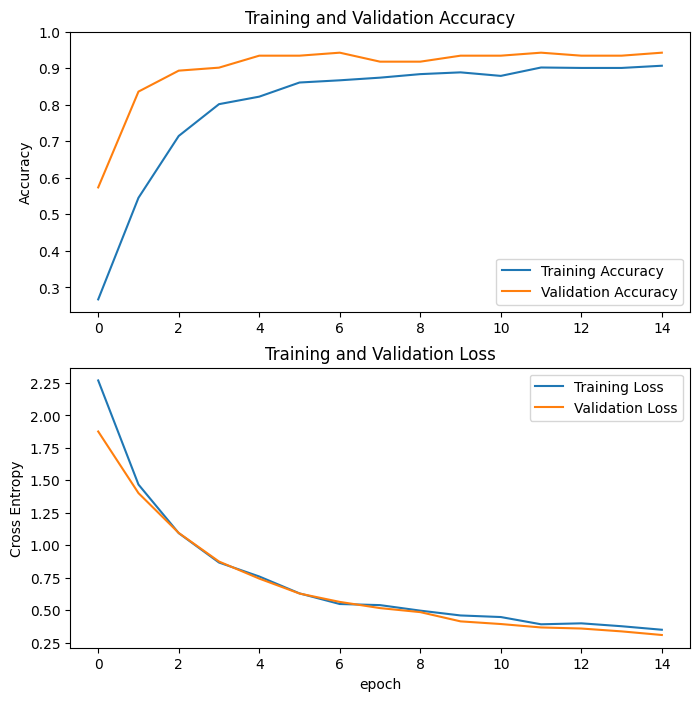

Final Training Loss: 0.3502
Final Validation Loss: 0.3098
Final Training Accuracy: 0.9069
Final Validation Accuracy: 0.9426


In [170]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

print(f"Final Training Loss: {loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")
print(f"Final Training Accuracy: {acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")

## Trainable = True
Sets classifier.trainable to true so that we can slightly train the weights with our dataset

In [171]:
classifier.trainable = True

In [172]:
#Get specific model
classifier_layer = classifier.get_layer('mobilenetv2_1.00_224')

# Explicitly set all layers within the base_model to trainable first.
for layer in classifier_layer.layers:
  layer.trainable = True

# Freeze the layers not in the fine_tune_layer. Only the layers in fine_tune_layers will be fined tuned
for layer in classifier_layer.layers[:fine_tune_layers]:
  layer.trainable = False

In [173]:
classifier.compile(optimizer=optimizer_val_tuning,
              loss=loss_val,
              metrics=["accuracy"])

In [174]:
classifier.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 400, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 400, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_5 (TrueDivide)      │ (None, 400, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_5 (Subtract)           │ (None, 400, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 13, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 30)             │        38,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,296,414 (8.76 MB)

 Trainable params: 2,106,142 (8.03 MB)

 Non-trainable params: 190,272 (743.25 KB)

In [175]:
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = classifier.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds)

Epoch 16/27
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 276ms/step - accuracy: 0.7970 - loss: 0.6323 - val_accuracy: 0.9344 - val_loss: 0.1747
Epoch 17/27
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.9191 - loss: 0.2591 - val_accuracy: 0.9344 - val_loss: 0.1757
Epoch 18/27
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.9412 - loss: 0.1828 - val_accuracy: 0.9262 - val_loss: 0.1796
Epoch 19/27
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.9584 - loss: 0.1726 - val_accuracy: 0.9590 - val_loss: 0.1152
Epoch 20/27
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.9747 - loss: 0.1060 - val_accuracy: 0.9344 - val_loss: 0.1611
Epoch 21/27
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.9659 - loss: 0.1064 - val_accuracy: 0.9344 - val_loss: 0.1464
Epoch 22/27
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.9705 - loss: 0.0931 - val_accuracy: 0.9344 - val_loss: 0.1531
Epoch 23/27
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.9758 - loss: 0.0764 - val_acc

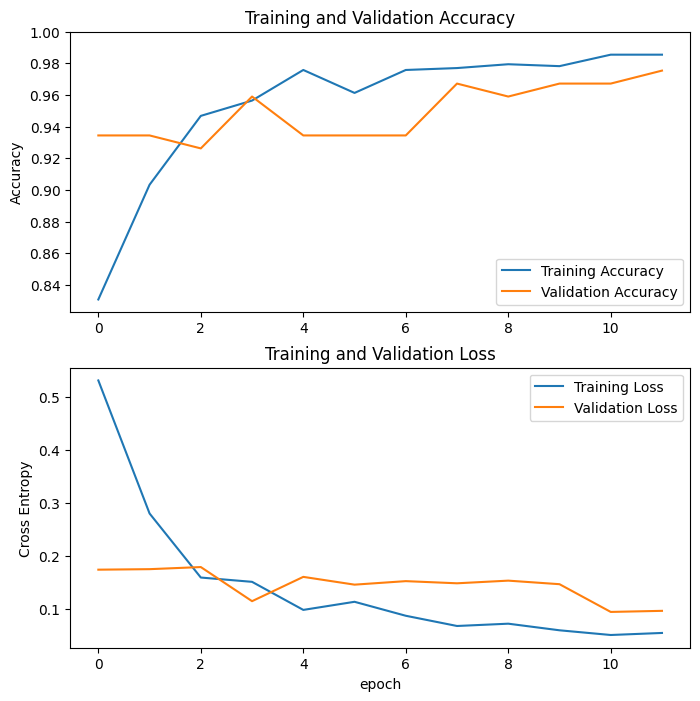

Final Training Loss: 0.0552
Final Validation Loss: 0.0970
Final Training Accuracy: 0.9855
Final Validation Accuracy: 0.9754


In [176]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

print(f"Final Training Loss: {loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")
print(f"Final Training Accuracy: {acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")

# Testing

In [177]:
#Cause Unaturally high accuracy (1.0000) if we don't move some training data to testing data.
#Most likely due to limited size of test dataset being small
test_loss, test_accuracy = classifier.evaluate(test_ds)
print('Test Accuracy:v', test_accuracy)
print('Test Loss:v', test_loss)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9854 - loss: 0.0471
Test Accuracy:v 0.9851852059364319
Test Loss:v 0.04675908759236336


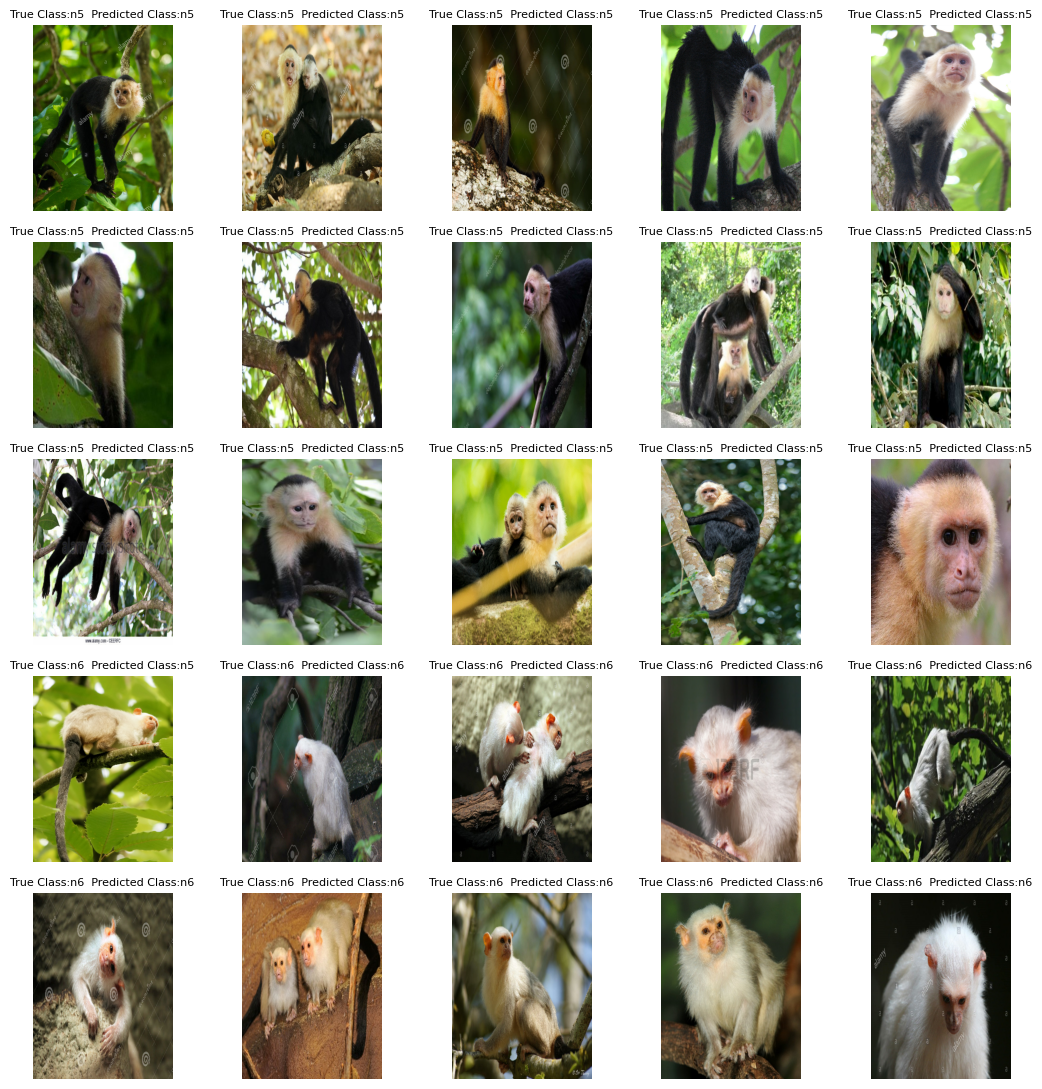

In [178]:
data_pt = next(iter(val_ds))
imgs, ys = data_pt
preds = classifier.predict(imgs, verbose=0)

plt.figure(figsize=(11,11))
for i in range(25):
    ax = plt.subplot(5,5,i+1)
    ax.imshow(imgs[i].numpy().astype("uint8")); ax.axis("off")
    t, p = int(ys[i].numpy()), int(np.argmax(preds[i]))
    ax.set_title(f"True Class:{class_names[t]}  Predicted Class:{class_names[p]}", fontsize=8)
plt.tight_layout()